In [3]:
import os
CODE_DIR = '/home/csp-uts/Hanyu/pixel2style2pixel-master/'
os.chdir(f'{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(".")
sys.path.append("..")

from scripts import id_loss_cal
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

# data path is a temporary path to save image generated in loop
data_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_generated'
# gt path is a temporary path to save original image generated from latent code
gt_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_groundtruth'
# image path is the path of original image
image_path = CODE_DIR+'notebooks/images/00000/00003.png'
# target image path is the path when using targeted mode
targeted_image_path = CODE_DIR+'notebooks/images/00000/00001.png'
# path image gen and path image gt is the path of temp image
path_image_gen = data_path+'/temp_image.png'
path_image_GT = gt_path+'/temp_image.png'
# latent avg path is the path of average latent, use it for untargeted mode
latent_avg_path = CODE_DIR+'notebooks/results/average_latent.npy'
latent_AVG = np.load(latent_avg_path)


experiment_type = 'ffhq_encode'

EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
pprint.pprint(opts)
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': 'pretrained_models/psp_ffhq_encode.pt',
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [4]:
def run_on_batch(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=False, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def run_on_gen(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=True, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def hy_latent(latent_np):
#     hy_latent = torch.from_numpy(np.array([latent_np]))
    hy_latent = torch.from_numpy(latent_np)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

def Image2Image_initial(image,targeted_image_path,path_img_gen,path_img_GT,latent_average,input_img_path=True,targeted=True):
    if input_img_path:
        image_path = image
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        print('load image from:',image)
    else:
        original_image = image.convert("RGB")
        print('load image from Input image')
        
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    transformed_image = img_transforms(original_image)

    with torch.no_grad():
        tic = time.time()
        result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        toc = time.time()
        print('Generate original latent code took {:.4f} seconds.'.format(toc - tic))
        
    result_image.size()
    result_image = result_image[0]
    output_image = tensor2im(result_image)
    res_image = Image.fromarray(np.array(output_image.resize((256, 256))))
    plt.imshow(res_image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    res_image.save(path_img_GT)
    
    if targeted:
        print('select target image from:',targeted_image_path)
        generated_image = Image.open(targeted_image_path)
        generated_image = generated_image.convert("RGB")
        
        transformed_image_g = img_transforms(generated_image)
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_batch(transformed_image_g.unsqueeze(0), net)
            toc = time.time()
            print('Generate targeted image latent code took {:.4f} seconds.'.format(toc - tic))
            
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Targeted Image')
        plt.show()
        res_image_g.save(path_img_gen)
        
    else:
        print('untargeted mode use average latent code')
        
        latent_avg = latent_average
        latent2cuda = latent_avg
        latent_tensor = hy_latent(latent2cuda)
#         latent_tensor.shape
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_gen(latent_tensor.unsqueeze(0), net)
            toc = time.time()
            print('Generate untargeted image from average latent code took {:.4f} seconds.'.format(toc - tic))
        
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Untargeted Image')
        plt.show()
        res_image_g.save(path_img_gen)

    return codes,codes_g,path_img_GT,path_img_gen

def generate_latent_from_path(img_path,net):
    img_list = os.listdir(img_path)
    img_list.sort()
    len_img = len(img_list)
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    
    latent_list = np.zeros([int(len_img),18,512])
    assert len_img!=0, "No image in folder"
    print(len_img,'images in folder!')
    
    for i in range(len_img):
        image_path = img_path+'/'+img_list[i]
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        
        transformed_image = img_transforms(original_image)

        with torch.no_grad():
            result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        
        latent_np = latent.cpu().detach().numpy()
        latent_list[i] = latent_np[0]
        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
    print('latent generation complete!')    
    return latent_list

# Generate latent code from Path

In [178]:
input_img_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/10000'
latent_list = generate_latent_from_path(input_img_path,net)
print(latent_list.shape)

1000 images in folder!
Processing: 100.0% [1000/1000]
latent generation complete!
(1000, 18, 512)


In [179]:
index = input_img_path[-5:-3]
path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_original_'+index+'.npy'
np.save(path,latent_list)

Generate untargeted image from average latent code took 0.0263 seconds.


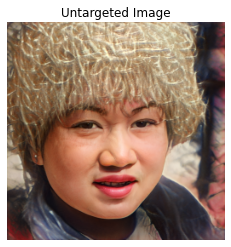

In [180]:
latent_tensor = hy_latent(latent_list[1])
#         latent_tensor.shape

with torch.no_grad():
    tic = time.time()
    result_image_g, latent_g,codes_g = run_on_gen(latent_tensor.unsqueeze(0), net)
    toc = time.time()
    print('Generate untargeted image from average latent code took {:.4f} seconds.'.format(toc - tic))

result_image_g.size()
result_image_g = result_image_g[0]
output_image_g = tensor2im(result_image_g)
res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
plt.imshow(res_image_g)
plt.axis('off')
plt.title('Untargeted Image')
plt.show()

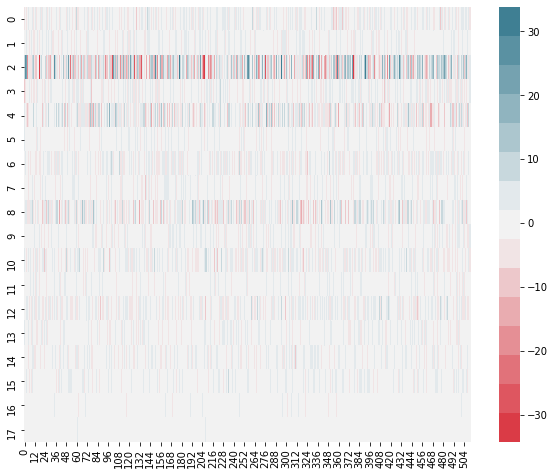

In [149]:
plt.figure(figsize=(10, 8))
# sns.heatmap(latent[0],cmap=sns.diverging_palette(10, 220, sep=20, n=15),vmin=-2, vmax=2)
sns.heatmap(latent_list[0],cmap=sns.diverging_palette(10, 220, sep=20, n=15))

# Generator Initialization

load image from: /home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/01000/01695.png
Generate original latent code took 0.1105 seconds.


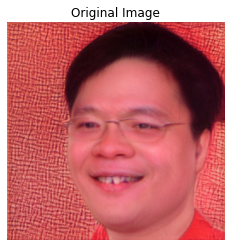

select target image from: /home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/03000/03363.png
Generate targeted image latent code took 0.0881 seconds.


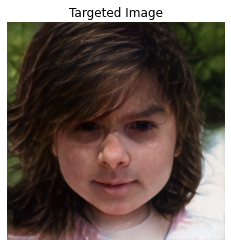

In [3]:
%matplotlib inline
image_path = CODE_DIR+'notebooks/images/01000/01695.png'
targeted_image_path = CODE_DIR+'notebooks/images/03000/03363.png'

codes,codes_g,path_img_GT,path_img_gen = Image2Image_initial(image=image_path,
                                                             targeted_image_path=targeted_image_path,
                                                             path_img_gen=path_image_gen,
                                                             path_img_GT=path_image_GT,
                                                             latent_average=latent_AVG,
                                                             input_img_path=True,
                                                             targeted=True)

In [10]:
from numpy import linalg as LA
np_codes = codes.cpu().detach().numpy()
np_codes_g = codes_g.cpu().detach().numpy()
aaa = (np_codes[0]-np_codes_g[0]).flatten()
a = LA.norm(aaa,ord=1)
print(a)

14534.155


In [12]:
import copy
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
print(latent_code.shape)

(10995, 18, 512)


In [37]:
count = 0
for i in range(10995):
    for j in range(10995):
        if j>i:
            count = count+1
            if count==36870574:
                print(i,j,count)
                latent1 = latent_code[i]
                latent2 = latent_code[j]
                latent_sub = (latent1-latent2).flatten()
                a = LA.norm(latent_sub,ord=1)
                print(a)
                break

4128 9598 36870574
3461.452496459242


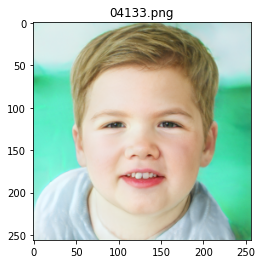

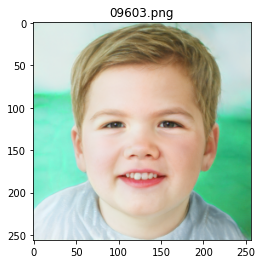

In [38]:
latent1_hy = hy_latent(latent1)
latent2_hy = hy_latent(latent2)
with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(latent1_hy.unsqueeze(0), net)
        
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
plt.imshow(res_image_temp)
plt.title('04133.png')
plt.show()
with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(latent2_hy.unsqueeze(0), net)
        
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
plt.imshow(res_image_temp)
plt.title('09603.png')
plt.show()

# Generate AD noise on one image

In [58]:
alpha = 0

file_paths = [[path_image_gen,path_image_GT]]
score_temp = id_loss_cal.extract_on_paths(file_paths)
ID_score = score_temp['temp_image.png']
print(ID_score)       
# mp.set_start_method('spawn')# good solution !!!
while ID_score<0.2:      
    latent_hy = alpha*codes+(1-alpha)*codes_g
    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(latent_hy, net)
        
    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(path_img_gen)

    alpha = alpha+0.05
    score_temp = id_loss_cal.extract_on_paths(file_paths)
#         score_temp = mp.Process(target=clac_loss, args=(data_path,gt_path,1))
    
    ID_score = score_temp['temp_image.png']
    print(alpha)
    print(ID_score)
    

-0.021226955577731133
0.05
-0.021226955577731133
0.1
-0.010611949488520622
0.15000000000000002
-0.014665033668279648
0.2
-0.018360629677772522
0.25
-0.008682137355208397
0.3
0.004357495345175266
0.35
0.08813899010419846
0.39999999999999997
0.14628857374191284
0.44999999999999996
0.18651741743087769
0.49999999999999994
0.21789278090000153


# Generate AD noise for images in path

In [118]:
Groundtruth_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGroundtruth'
GeneratedIMG_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGenerated_Untargeted_all_03'

list1=os.listdir(Groundtruth_path)
list1.sort()

latent_avg = latent_AVG
latent2cuda = latent_avg
latent_tensor = hy_latent(latent2cuda)
    
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

Unaligned_image = []

for i in range(len(list1)):
    gt_path = Groundtruth_path+'/'+list1[i]
    gen_path = GeneratedIMG_path+'/'+list1[i]
    alpha = 0
    if os.path.exists(gen_path):
        print('already exist image:',gen_path)
        continue
    else:
        gt_image = Image.open(gt_path)
        gt_image = gt_image.convert("RGB")
    #     print('load image from:',gt_path)

        transformed_gt_image = img_transforms(gt_image) 

        with torch.no_grad():
            _, _, gt_codes = run_on_batch(transformed_gt_image.unsqueeze(0), net)

        with torch.no_grad():
            result_image_g, _,gen_codes = run_on_gen(latent_tensor.unsqueeze(0), net)

        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))


        score_temp = id_loss_cal.extract_on_images(gt_image,res_image_g,gt_path)
        if score_temp == None:
            Unaligned_image.append(i)
            print('skping image:',list1[i])
            continue
        else:
            ID_score = score_temp[os.path.basename(gt_path)]
            print(os.path.basename(gt_path))
            print('initial score =',ID_score)       

            while ID_score<0.3:      
                latent_hy = alpha*gt_codes+(1-alpha)*gen_codes
                with torch.no_grad():
                    result_image_temp, _,_ = run_on_gen(latent_hy, net)

                result_image_temp = result_image_temp[0]
                output_image_temp = tensor2im(result_image_temp)
                res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))


                alpha = alpha+0.1
                score_temp = id_loss_cal.extract_on_images(gt_image,res_image_temp,gt_path)
                if score_temp == None:
                    Unaligned_image.append(i)
                    print('skping image:',list1[i])
                    break
                else:
                    ID_score = score_temp[os.path.basename(gt_path)]
                    
            print('alpha=',alpha)
            print('final score=',ID_score)
            res_image_temp.save(gen_path)
            print('* '*20)

print('Complete!')

00000.png
initial score = 0.09029887616634369
alpha= 0.6
final score= 0.38116729259490967
* * * * * * * * * * * * * * * * * * * * 
00001.png
initial score = -0.027443639934062958
alpha= 0.5
final score= 0.4244428277015686
* * * * * * * * * * * * * * * * * * * * 
00002.png
initial score = 0.04761242866516113
alpha= 0.5
final score= 0.3014458119869232
* * * * * * * * * * * * * * * * * * * * 
00003.png
initial score = 0.02676071971654892
alpha= 0.7
final score= 0.4123247265815735
* * * * * * * * * * * * * * * * * * * * 
00004.png
initial score = 0.04237932711839676
alpha= 0.4
final score= 0.3973146677017212
* * * * * * * * * * * * * * * * * * * * 
00005.png
initial score = -0.07735846936702728
alpha= 0.5
final score= 0.315293550491333
* * * * * * * * * * * * * * * * * * * * 
00006.png
initial score = 0.12252756953239441
alpha= 0.5
final score= 0.3979502320289612
* * * * * * * * * * * * * * * * * * * * 
00007.png
initial score = 0.09280139207839966
alpha= 0.6
final score= 0.333119928836822

00062.png
initial score = -0.12491863965988159
alpha= 0.7
final score= 0.4050101935863495
* * * * * * * * * * * * * * * * * * * * 
00063.png
initial score = 0.06568644940853119
alpha= 1.0999999999999999
final score= 0.3035860061645508
* * * * * * * * * * * * * * * * * * * * 
00064.png
initial score = 0.016786806285381317
alpha= 0.5
final score= 0.3515459895133972
* * * * * * * * * * * * * * * * * * * * 
00065.png
initial score = 0.06707429140806198
alpha= 0.4
final score= 0.3195323348045349
* * * * * * * * * * * * * * * * * * * * 
00066.png
initial score = -0.15586212277412415
alpha= 0.7999999999999999
final score= 0.30709683895111084
* * * * * * * * * * * * * * * * * * * * 
00067.png
initial score = 0.17991957068443298
alpha= 0.30000000000000004
final score= 0.40138089656829834
* * * * * * * * * * * * * * * * * * * * 
00068.png
initial score = -0.026027053594589233
alpha= 0.7
final score= 0.3748488426208496
* * * * * * * * * * * * * * * * * * * * 
00069.png
initial score = 0.071452178

00124.png
initial score = 0.12095083296298981
alpha= 0.4
final score= 0.35307562351226807
* * * * * * * * * * * * * * * * * * * * 
00125.png
initial score = 0.07200677692890167
alpha= 0.7
final score= 0.32832837104797363
* * * * * * * * * * * * * * * * * * * * 
00126.png
initial score = -0.0888323038816452
alpha= 0.5
final score= 0.3630593419075012
* * * * * * * * * * * * * * * * * * * * 
00127.png
initial score = -0.030272485688328743
alpha= 0.5
final score= 0.4111752212047577
* * * * * * * * * * * * * * * * * * * * 
00128.png
initial score = 0.11192933470010757
alpha= 0.4
final score= 0.33299684524536133
* * * * * * * * * * * * * * * * * * * * 
00129.png
initial score = 0.09861487150192261
alpha= 0.4
final score= 0.3117676377296448
* * * * * * * * * * * * * * * * * * * * 
00130.png
initial score = 0.05643485486507416
alpha= 0.5
final score= 0.3086380958557129
* * * * * * * * * * * * * * * * * * * * 
00131.png
initial score = -0.04443525895476341
alpha= 0.6
final score= 0.338106095790

alpha= 0.7
final score= 0.3134029507637024
* * * * * * * * * * * * * * * * * * * * 
00187.png
initial score = 0.01852668635547161
alpha= 0.5
final score= 0.32382336258888245
* * * * * * * * * * * * * * * * * * * * 
00188.png
initial score = -0.04244604334235191
alpha= 0.6
final score= 0.3313296139240265
* * * * * * * * * * * * * * * * * * * * 
00189.png
initial score = -0.11618467420339584
alpha= 0.7
final score= 0.40621131658554077
* * * * * * * * * * * * * * * * * * * * 
00190.png
initial score = -0.03481052443385124
alpha= 0.7
final score= 0.323577344417572
* * * * * * * * * * * * * * * * * * * * 
00191.png
initial score = 0.07361863553524017
alpha= 0.7
final score= 0.38883668184280396
* * * * * * * * * * * * * * * * * * * * 
00192.png
initial score = 0.17831411957740784
alpha= 0.4
final score= 0.3548980951309204
* * * * * * * * * * * * * * * * * * * * 
00193.png
initial score = -0.10315527766942978
alpha= 0.7
final score= 0.31948724389076233
* * * * * * * * * * * * * * * * * * * * 

00249.png
initial score = 0.21727821230888367
alpha= 0.30000000000000004
final score= 0.3405963182449341
* * * * * * * * * * * * * * * * * * * * 
00250.png
initial score = -0.07104101777076721
alpha= 0.7
final score= 0.30585363507270813
* * * * * * * * * * * * * * * * * * * * 
00251.png
initial score = -0.062251731753349304
alpha= 0.5
final score= 0.3456970155239105
* * * * * * * * * * * * * * * * * * * * 
00252.png
initial score = -0.004110853187739849
alpha= 0.5
final score= 0.36602193117141724
* * * * * * * * * * * * * * * * * * * * 
00253.png
initial score = 0.013157660141587257
alpha= 0.6
final score= 0.3032076954841614
* * * * * * * * * * * * * * * * * * * * 
00254.png
initial score = -0.04489072412252426
alpha= 0.7
final score= 0.34955042600631714
* * * * * * * * * * * * * * * * * * * * 
00255.png
initial score = -0.002567875199019909
alpha= 0.5
final score= 0.3154600262641907
* * * * * * * * * * * * * * * * * * * * 
00256.png
initial score = -0.031013596802949905
alpha= 0.6
fin

00311.png
initial score = 0.06705938279628754
alpha= 0.5
final score= 0.3135877549648285
* * * * * * * * * * * * * * * * * * * * 
00312.png
initial score = 0.05516146868467331
alpha= 0.6
final score= 0.4110690951347351
* * * * * * * * * * * * * * * * * * * * 
00313.png
initial score = -0.03956906497478485
alpha= 0.6
final score= 0.32303744554519653
* * * * * * * * * * * * * * * * * * * * 
00314.png
initial score = 0.09782427549362183
alpha= 0.5
final score= 0.3880637288093567
* * * * * * * * * * * * * * * * * * * * 
00315.png
initial score = -0.02872539684176445
alpha= 0.5
final score= 0.3369942903518677
* * * * * * * * * * * * * * * * * * * * 
00316.png
initial score = -0.022542111575603485
alpha= 0.6
final score= 0.3363116681575775
* * * * * * * * * * * * * * * * * * * * 
00317.png
initial score = 0.017292089760303497
alpha= 0.5
final score= 0.3044513463973999
* * * * * * * * * * * * * * * * * * * * 
00318.png
initial score = 0.07326935231685638
alpha= 0.5
final score= 0.358944416046

00373.png
initial score = 0.08381208777427673
alpha= 0.4
final score= 0.34187304973602295
* * * * * * * * * * * * * * * * * * * * 
00374.png
initial score = -0.0910315290093422
alpha= 0.5
final score= 0.35451677441596985
* * * * * * * * * * * * * * * * * * * * 
00375.png
initial score = -0.0036330176517367363
alpha= 0.7
final score= 0.35188937187194824
* * * * * * * * * * * * * * * * * * * * 
00376.png
initial score = 0.06971317529678345
alpha= 0.6
final score= 0.31953588128089905
* * * * * * * * * * * * * * * * * * * * 
00377.png
initial score = -0.023486919701099396
alpha= 0.6
final score= 0.3242875337600708
* * * * * * * * * * * * * * * * * * * * 
00378.png
initial score = 0.07130451500415802
alpha= 0.5
final score= 0.41133224964141846
* * * * * * * * * * * * * * * * * * * * 
00379.png
initial score = -0.03262268379330635
alpha= 0.5
final score= 0.3178676664829254
* * * * * * * * * * * * * * * * * * * * 
00380.png
initial score = 0.1194225400686264
alpha= 0.4
final score= 0.37889319

00435.png
initial score = 0.014444548636674881
alpha= 0.5
final score= 0.34238600730895996
* * * * * * * * * * * * * * * * * * * * 
00436.png
initial score = -0.07959771156311035
alpha= 0.6
final score= 0.36327797174453735
* * * * * * * * * * * * * * * * * * * * 
00437.png
initial score = 0.04430672898888588
alpha= 0.4
final score= 0.312723845243454
* * * * * * * * * * * * * * * * * * * * 
00438.png
initial score = 0.052464764565229416
alpha= 0.7
final score= 0.37775251269340515
* * * * * * * * * * * * * * * * * * * * 
00439.png
initial score = -0.00047832168638706207
alpha= 0.5
final score= 0.3326355814933777
* * * * * * * * * * * * * * * * * * * * 
00440.png
initial score = 0.05941968783736229
alpha= 0.5
final score= 0.40466657280921936
* * * * * * * * * * * * * * * * * * * * 
00441.png
initial score = 0.021461298689246178
alpha= 0.6
final score= 0.3497539758682251
* * * * * * * * * * * * * * * * * * * * 
00442.png
initial score = -0.06989316642284393
alpha= 0.6
final score= 0.322761

00497.png
initial score = 0.04339936375617981
alpha= 0.4
final score= 0.3388216197490692
* * * * * * * * * * * * * * * * * * * * 
00498.png
initial score = 0.03111480176448822
alpha= 0.7
final score= 0.3795892894268036
* * * * * * * * * * * * * * * * * * * * 
00499.png
initial score = 0.00839410349726677
alpha= 0.5
final score= 0.3516286313533783
* * * * * * * * * * * * * * * * * * * * 
00500.png
initial score = 0.06369742006063461
alpha= 0.4
final score= 0.3325437605381012
* * * * * * * * * * * * * * * * * * * * 
00501.png
initial score = -0.00846436619758606
alpha= 0.6
final score= 0.30085819959640503
* * * * * * * * * * * * * * * * * * * * 
00502.png
initial score = 0.06486619263887405
alpha= 0.5
final score= 0.35280293226242065
* * * * * * * * * * * * * * * * * * * * 
00503.png
initial score = -0.04195399582386017
alpha= 0.5
final score= 0.33730578422546387
* * * * * * * * * * * * * * * * * * * * 
00504.png
initial score = -0.07695939391851425
alpha= 0.5
final score= 0.424005836248

00559.png
initial score = 0.01433421578258276
alpha= 0.6
final score= 0.3676975667476654
* * * * * * * * * * * * * * * * * * * * 
00560.png
initial score = -0.12312763929367065
alpha= 0.6
final score= 0.37203657627105713
* * * * * * * * * * * * * * * * * * * * 
00561.png
initial score = 0.08657743781805038
alpha= 0.4
final score= 0.3679126501083374
* * * * * * * * * * * * * * * * * * * * 
00562.png
initial score = 0.09566287696361542
alpha= 0.5
final score= 0.31599026918411255
* * * * * * * * * * * * * * * * * * * * 
00563.png
initial score = 0.032856203615665436
alpha= 0.4
final score= 0.3266463279724121
* * * * * * * * * * * * * * * * * * * * 
00564.png
initial score = 0.09167271852493286
alpha= 0.5
final score= 0.3532242178916931
* * * * * * * * * * * * * * * * * * * * 
00565.png
initial score = 0.17117023468017578
alpha= 0.4
final score= 0.31985846161842346
* * * * * * * * * * * * * * * * * * * * 
00566.png
initial score = 0.15659542381763458
alpha= 0.5
final score= 0.3528210520744

alpha= 0.4
final score= 0.3455311357975006
* * * * * * * * * * * * * * * * * * * * 
00622.png
initial score = 0.05468675121665001
alpha= 0.5
final score= 0.3589853048324585
* * * * * * * * * * * * * * * * * * * * 
00623.png
initial score = 0.034576889127492905
alpha= 0.4
final score= 0.31474852561950684
* * * * * * * * * * * * * * * * * * * * 
00624.png
initial score = -0.022696882486343384
alpha= 0.5
final score= 0.4060029685497284
* * * * * * * * * * * * * * * * * * * * 
00625.png
initial score = -0.010429762303829193
alpha= 0.6
final score= 0.36482417583465576
* * * * * * * * * * * * * * * * * * * * 
00626.png
initial score = 0.025924082845449448
alpha= 0.4
final score= 0.3049200177192688
* * * * * * * * * * * * * * * * * * * * 
00627.png
initial score = -0.09627175331115723
alpha= 0.6
final score= 0.33837008476257324
* * * * * * * * * * * * * * * * * * * * 
00628.png
initial score = 0.022765303030610085
alpha= 0.6
final score= 0.4248773157596588
* * * * * * * * * * * * * * * * * * 

alpha= 0.7
final score= 0.3603828549385071
* * * * * * * * * * * * * * * * * * * * 
00684.png
initial score = -0.06747670471668243
alpha= 0.5
final score= 0.335958331823349
* * * * * * * * * * * * * * * * * * * * 
00685.png
initial score = -0.06965579837560654
alpha= 0.7
final score= 0.324428915977478
* * * * * * * * * * * * * * * * * * * * 
00686.png
initial score = -0.0076471492648124695
alpha= 0.5
final score= 0.3522373139858246
* * * * * * * * * * * * * * * * * * * * 
00687.png
initial score = 0.0948575958609581
alpha= 0.5
final score= 0.3244819641113281
* * * * * * * * * * * * * * * * * * * * 
00688.png
initial score = 0.05801837146282196
alpha= 0.6
final score= 0.34456342458724976
* * * * * * * * * * * * * * * * * * * * 
00689.png
initial score = 0.029452066868543625
alpha= 0.5
final score= 0.3287471830844879
* * * * * * * * * * * * * * * * * * * * 
00690.png
initial score = -0.05040004104375839
alpha= 0.5
final score= 0.3368110656738281
* * * * * * * * * * * * * * * * * * * * 
0

00746.png
initial score = -0.021404068917036057
alpha= 0.5
final score= 0.3939747214317322
* * * * * * * * * * * * * * * * * * * * 
00747.png
initial score = 0.05828863009810448
alpha= 0.5
final score= 0.3001161217689514
* * * * * * * * * * * * * * * * * * * * 
00748.png
initial score = -0.029629871249198914
alpha= 0.6
final score= 0.34888291358947754
* * * * * * * * * * * * * * * * * * * * 
00749.png
initial score = 0.06610574573278427
alpha= 0.8999999999999999
final score= 0.3365222215652466
* * * * * * * * * * * * * * * * * * * * 
00750.png
initial score = 0.017093047499656677
alpha= 0.7
final score= 0.37202906608581543
* * * * * * * * * * * * * * * * * * * * 
00751.png
initial score = 0.18562115728855133
alpha= 0.4
final score= 0.34919649362564087
* * * * * * * * * * * * * * * * * * * * 
00752.png
initial score = 0.08027413487434387
alpha= 0.5
final score= 0.34821996092796326
* * * * * * * * * * * * * * * * * * * * 
00753.png
initial score = -0.07391467690467834
alpha= 0.5
final sc

alpha= 0.5
final score= 0.3114187717437744
* * * * * * * * * * * * * * * * * * * * 
00809.png
initial score = 0.05683574080467224
alpha= 0.5
final score= 0.3360665440559387
* * * * * * * * * * * * * * * * * * * * 
00810.png
initial score = -0.04733487591147423
alpha= 0.6
final score= 0.40030017495155334
* * * * * * * * * * * * * * * * * * * * 
00811.png
initial score = 0.001152707263827324
alpha= 0.6
final score= 0.3719842731952667
* * * * * * * * * * * * * * * * * * * * 
00812.png
initial score = 0.06500767171382904
alpha= 0.5
final score= 0.353095680475235
* * * * * * * * * * * * * * * * * * * * 
00813.png
initial score = 0.01696426421403885
alpha= 0.7999999999999999
final score= 0.3814016580581665
* * * * * * * * * * * * * * * * * * * * 
00814.png
initial score = 0.019060533493757248
alpha= 0.6
final score= 0.3680530786514282
* * * * * * * * * * * * * * * * * * * * 
00815.png
initial score = 0.08048553764820099
alpha= 0.4
final score= 0.30735212564468384
* * * * * * * * * * * * * * 

00870.png
initial score = 0.03841915726661682
alpha= 0.4
final score= 0.31745457649230957
* * * * * * * * * * * * * * * * * * * * 
00871.png
initial score = 0.08496173471212387
alpha= 0.4
final score= 0.36878082156181335
* * * * * * * * * * * * * * * * * * * * 
00872.png
initial score = -0.029231183230876923
alpha= 0.5
final score= 0.3557298183441162
* * * * * * * * * * * * * * * * * * * * 
00873.png
initial score = 0.08398739993572235
alpha= 0.5
final score= 0.33621710538864136
* * * * * * * * * * * * * * * * * * * * 
00874.png
initial score = -0.047500524669885635
alpha= 0.6
final score= 0.3028238117694855
* * * * * * * * * * * * * * * * * * * * 
00875.png
initial score = 0.07237155735492706
alpha= 0.4
final score= 0.3585299551486969
* * * * * * * * * * * * * * * * * * * * 
00876.png
initial score = -0.008365215733647346
alpha= 0.5
final score= 0.33974599838256836
* * * * * * * * * * * * * * * * * * * * 
00877.png
initial score = 0.006883901543915272
alpha= 0.6
final score= 0.3674467

00932.png
initial score = -0.027398748323321342
alpha= 0.6
final score= 0.34563833475112915
* * * * * * * * * * * * * * * * * * * * 
00933.png
initial score = -0.02338353544473648
alpha= 0.6
final score= 0.34353208541870117
* * * * * * * * * * * * * * * * * * * * 
00934.png
initial score = 0.055128708481788635
alpha= 0.5
final score= 0.31632742285728455
* * * * * * * * * * * * * * * * * * * * 
00935.png
initial score = -0.008917469531297684
alpha= 0.7
final score= 0.34301355481147766
* * * * * * * * * * * * * * * * * * * * 
00936.png
initial score = -0.03425367921590805
alpha= 0.4
final score= 0.30001235008239746
* * * * * * * * * * * * * * * * * * * * 
00937.png
initial score = -0.0012779822573065758
alpha= 0.5
final score= 0.34791961312294006
* * * * * * * * * * * * * * * * * * * * 
00938.png
initial score = 0.07553227245807648
alpha= 0.6
final score= 0.31373634934425354
* * * * * * * * * * * * * * * * * * * * 
00939.png
initial score = -0.005358993075788021
alpha= 0.5
final score= 0

alpha= 0.5
final score= 0.36002033948898315
* * * * * * * * * * * * * * * * * * * * 
00995.png
initial score = -0.0808396264910698
alpha= 0.5
final score= 0.31837978959083557
* * * * * * * * * * * * * * * * * * * * 
00996.png
initial score = 0.07592779397964478
alpha= 0.4
final score= 0.39072561264038086
* * * * * * * * * * * * * * * * * * * * 
00997.png
initial score = 0.06726644933223724
alpha= 0.5
final score= 0.3762182295322418
* * * * * * * * * * * * * * * * * * * * 
00998.png
initial score = 0.008099578320980072
alpha= 0.5
final score= 0.34733206033706665
* * * * * * * * * * * * * * * * * * * * 
00999.png
initial score = 0.11237163096666336
alpha= 0.4
final score= 0.3114399313926697
* * * * * * * * * * * * * * * * * * * * 
Complete!


# Compare images ID score in path with facenet

In [119]:
Unaligned_image

[49, 194, 290, 658]

In [4]:
!export PYTHONPATH=/home/wen/study/facenet/src

In [123]:
sys.path.append("/home/csp-uts/Hanyu/facenet/src")
from face_ID_loss import load_and_align_data,clac_loss
import facenet
model = '/home/csp-uts/Hanyu/facenet/models/VGGFace2/20180402-114759'
Groundtruth_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGroundtruth'
GeneratedIMG_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGenerated_Untargeted_all_03'
margin = 44
image_size = 160
gpu_memory_fraction = 0.4
list1=os.listdir(GeneratedIMG_path)
list1.sort()
gt_image_paths = []
gen_image_paths = []
for i in range(len(list1)):
    gt_path = Groundtruth_path+'/'+list1[i]
    gen_path = GeneratedIMG_path+'/'+list1[i]
    gt_image_paths.append(gt_path)
    gen_image_paths.append(gen_path)
# print(gt_image_paths,gen_image_paths)
#     print('load image from:',gt_path)
# gt_image,gen_image = load_and_align_data(gt_image_paths,gen_image_paths,image_size,margin,gpu_memory_fraction=0.4)
print(len(gt_image_paths),len(gen_image_paths))

996 996


In [124]:
dist_list = clac_loss(model, gt_image_paths, gen_image_paths, image_size, margin, gpu_memory_fraction)

Creating networks and loading parameters
Model directory: /home/csp-uts/Hanyu/facenet/models/VGGFace2/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /home/csp-uts/Hanyu/facenet/models/VGGFace2/20180402-114759/model-20180402-114759.ckpt-275


In [125]:
dist_array = np.array(dist_list)
np.save('Embedding_L2_Distance_03.npy',dist_array)

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


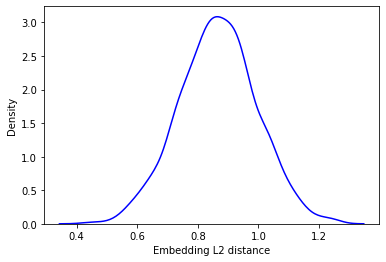

In [126]:
sns.distplot(dist_array, hist=False, kde=True,
             bins=int(180/5), color = 'blue',
             axlabel = 'Embedding L2 distance',
             hist_kws={'edgecolor':'black'})
# plt.savefig('L1_norm_high.png')

In [102]:
!python /home/csp-uts/Hanyu/facenet/src/compare.py /home/csp-uts/Hanyu/facenet/models/VGGFace2/20180402-114759 /home/csp-uts/Hanyu/StyleGAN2-Face-Modificator-master/results/race_white/000.png --gpu_memory_fraction=0.4

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csp-uts/anaconda3/envs/Hanyu

2020-11-10 21:58:53.414838: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7
2020-11-10 21:58:54.009285: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2020-11-10 21:58:54.153228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-10 21:58:54.153420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.65
pciBusID: 0000:01:00.0
2020-11-10 21:58:54.153459: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2020-11-10 21:58:54.153470: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcu

In [129]:
import requests
import json
import http.client, urllib.request, urllib.parse, urllib.error, base64

def find_faceID(image_path):
    # set to your own subscription key value
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'

    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/detect'

    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/3/37/Dagestani_man_and_woman.jpg'
    # Set image_path to the local path of an image that you want to analyze.
    image_path = image_path

    # Read the image into a byte array
    image_data = open(image_path, "rb").read()

    headers = {
      'Content-Type': 'application/octet-stream',
      'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
      'returnFaceId': 'true',
      'returnFaceLandmarks': 'false',
      # 'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    response = requests.post(face_api_url, params=params,
                          headers=headers, data=image_data)
    if type(response.json()) is list:
        if len(response.json()) != 0:
            faceId = response.json()[0]['faceId']
        else:
            faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    else:
        faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    # print(json.dumps(response.json()))
    # print(response.json()[0]['faceId'])
    return faceId


def isIdenticalll(faceid1,faceid2):
    '''
    This function verify the two face are same or not,
    faceid1: str, the id of face to be test,
    faceid2: str, the id of face original.
    '''
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'
    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/verify'

    headers = {
      # Request headers
      'Content-Type': 'application/json',
      'Ocp-Apim-Subscription-Key': subscription_key,
    }

    params = {
      "faceId1": faceid1,
      "faceId2": faceid2,
    }

    body = json.dumps(params)

    import requests
    from pprint import pprint
    response  = requests.post(face_api_url, headers=headers,data=body)
    result = response.json()
    # confi = result['confidence']
    # isId = result['isIdentical']
    # pprint(result['confidence'])
    # pprint(result['isIdentical'])
    return result

In [133]:
original_path = Groundtruth_path+'/'+list1[0]
faceId2 = find_faceID(original_path)
print(original_path)
print(faceId2)

/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGroundtruth/00000.png
9661f92e-1012-45c8-abed-3602c2b38540


In [134]:
Gener_path = GeneratedIMG_path+'/'+list1[0]
faceId1 = find_faceID(Gener_path)
print(Gener_path)
print(faceId1)

/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/IMGGenerated_Untargeted_all_03/00000.png
61d9377d-22e5-4ac2-8fd0-a1d3a13a5ad2


In [135]:
re = isIdenticalll(faceId1,faceId2)
print(re)

{'isIdentical': False, 'confidence': 0.47946}
